__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_3/Simulation_data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
ml     = 5.00                                                          #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

### Reading Data

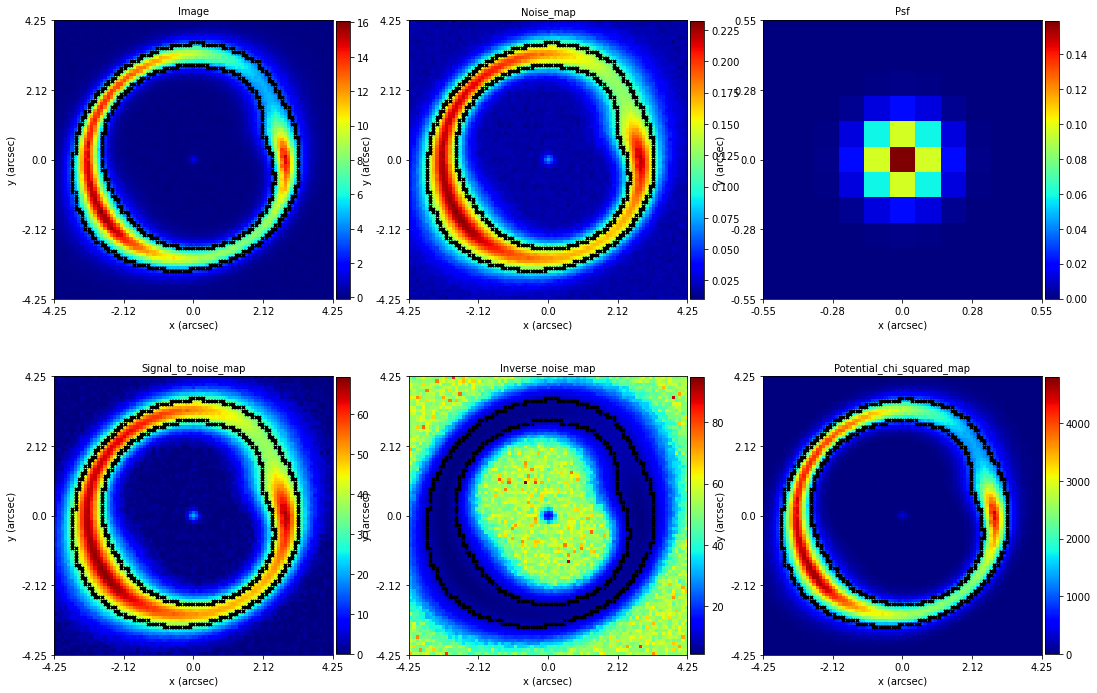

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

#Load mask

mask_custom = al.Mask.from_fits(
    file_path=f"{data_folder}/new_mask.fits", hdu=1, pixel_scales=imaging.pixel_scales
)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask_custom)


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask_custom, include=aplt.Include(border=False),                         #Plot
)

## Starting model
Here we define the lens mass profile (MGE in our case)

In [5]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_ * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [6]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_s)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 5.0378728629984835


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the inversion.

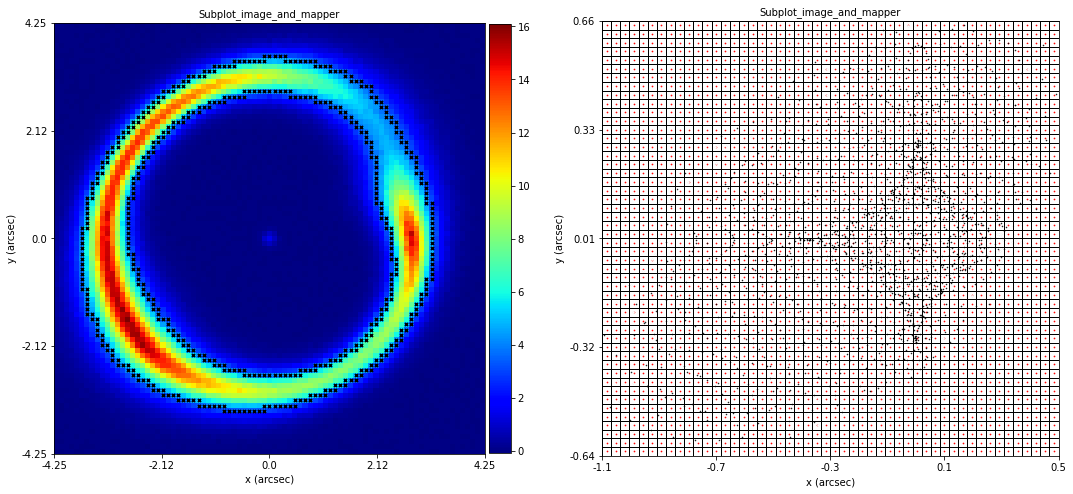

In [7]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [8]:
inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
)

Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

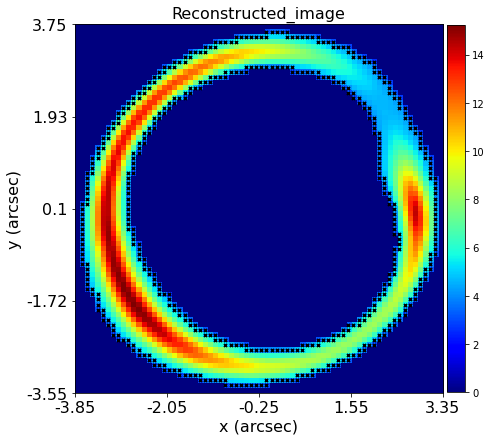

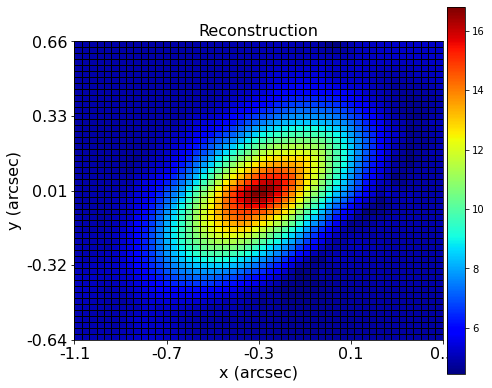

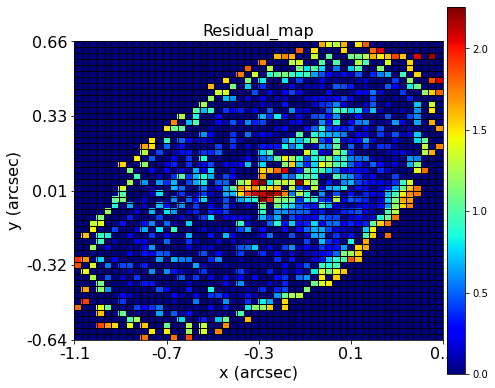

In [9]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

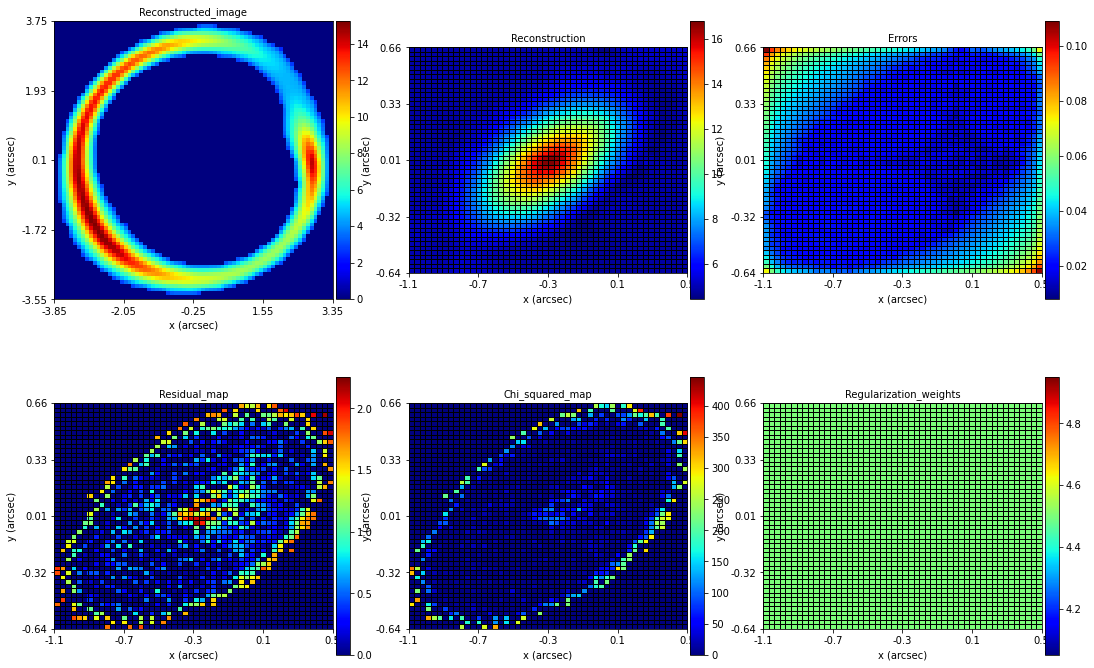

In [10]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion_new_mask", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(mask=False,inversion_border=False,
                                                                 inversion_pixelization_grid=False,))

## Voronoi Inversion

In [11]:
voronoi = al.pix.VoronoiMagnification(shape=(50,50))

image_plane_sparse_grid = voronoi.sparse_grid_from_grid(grid=masked_image.grid)

source_galaxy_voronoi = al.Galaxy(
    redshift=z_s, pixelization=voronoi, regularization=al.reg.Constant(coefficient=3.5)
)


tracer_voronoi = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_voronoi])

Elapsed time 3.006141730998934
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


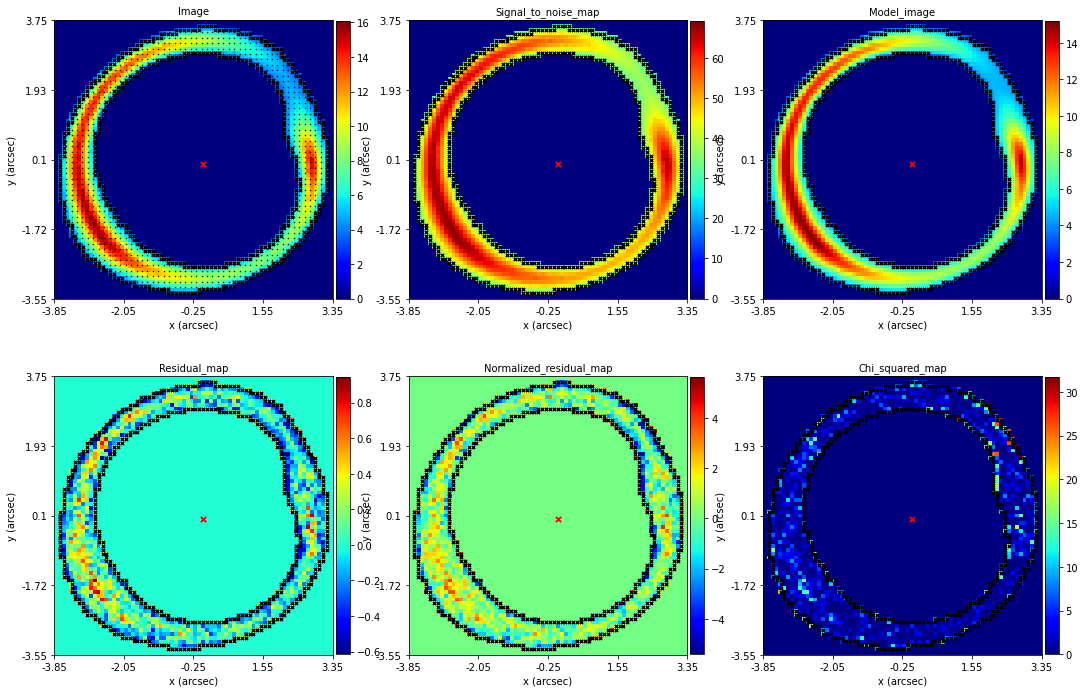

In [12]:
start = clock()
fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer_voronoi)
print("Elapsed time", clock() - start)

output=aplt.Output(path=data_folder,filename="Voronoi_Inversion_1_new_mask", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.FitImaging.subplot_fit_imaging(sub_plotter=plotter,
    fit=fit,
    include=aplt.Include(
        mask=True,
        inversion_image_pixelization_grid=True,
        inversion_pixelization_grid=True,
    ),
)



#Plot
aplt.FitImaging.subplot_fit_imaging(
    fit=fit,
    include=aplt.Include(
        mask=True,
        inversion_image_pixelization_grid=True,
        inversion_pixelization_grid=True,
    ),
)


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Caustics could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Caustics could not be calculated due to an unphysical mass model


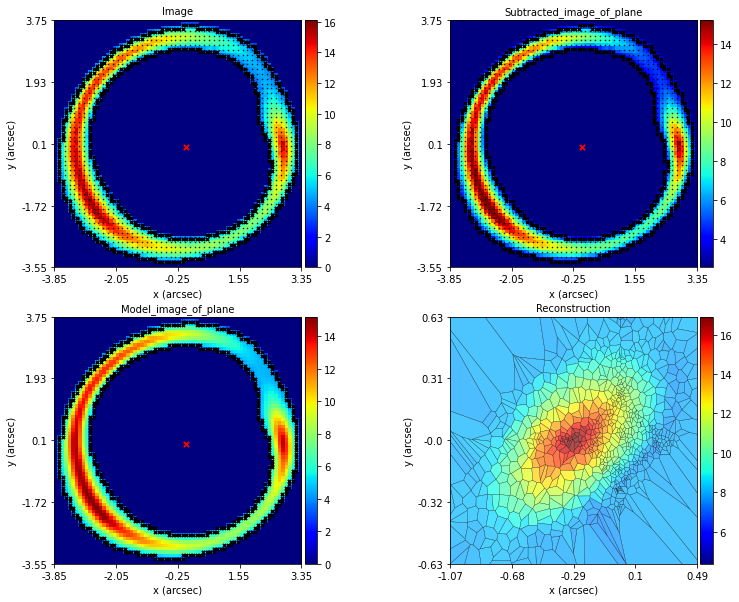

In [13]:
output=aplt.Output(path=data_folder,filename="Voronoi_Inversion_2_new_mask", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.FitImaging.subplot_of_plane(sub_plotter=plotter,
    fit=fit, plane_index=1, include=aplt.Include(mask=True, inversion_pixelization_grid=False,
                                                            inversion_border=False)
)

#Plot
aplt.FitImaging.subplot_of_plane(
    fit=fit, plane_index=1, include=aplt.Include(mask=True, inversion_pixelization_grid=False,
                                                            inversion_border=False)
)